## Approach Plan
1. Data Exploration
2. Create task dataset
3. Make MOO
4. RL - CL
5. RL - Dedicated Model
6. Comparison

# Load Data

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to your datasets
task_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'  # Update this if the filename changes
employee_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'

# Load the datasets
df_tasks_original = pd.read_csv(task_data_path)
df_employees_original = pd.read_csv(employee_data_path)

# Extract skill columns from tasks and employees as lists
# New task structure: task_name, epic, story_points, then skills (cols 3 onward)
task_skill_cols = [col for col in df_tasks_original.columns[3:]]  # Skills start after task_name, epic, story_points
employee_skill_cols = [col for col in df_employees_original.columns[2:]]  # Skills from col 2 onward

# Find common skills and convert to list
common_skills = list(set(task_skill_cols).intersection(employee_skill_cols))

# Filter dataframes to common skills plus key columns
df_tasks = df_tasks_original[['task_id', 'story_points'] + common_skills]
df_employees = df_employees_original[['employee_id', 'Role'] + common_skills]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

## Task Dataset

Mounted at /content/drive


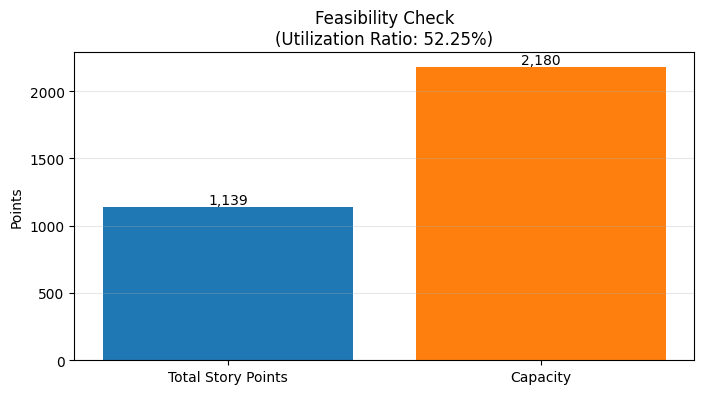

Total Story Points: 1139, Capacity: 2180, Ratio: 0.52


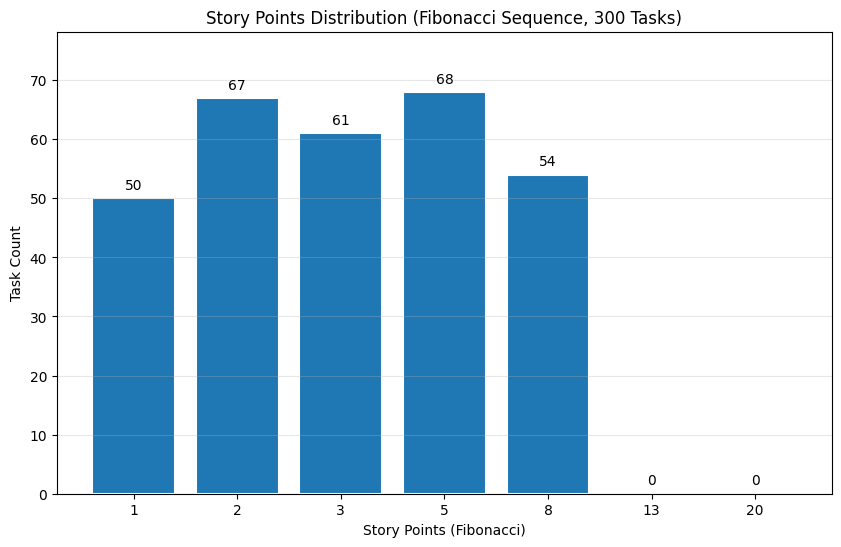

Fibonacci Story Points Counts:
 story_points
1     50
2     67
3     61
5     68
8     54
13     0
20     0
Name: count, dtype: int64
Story Points Bins:
 story_points
(-0.001, 5.0]    246
(5.0, 10.0]       54
(10.0, 15.0]       0
(15.0, 20.0]       0
Name: count, dtype: int64
Employee Sparsity: 0.01%, Task Sparsity: 16.73%
Mean Employee Skill (non-zero): 2.86
Mean Task Skill (non-zero): 3.01
Theoretical WED Range: Worst=0.0270, Best=1.0000


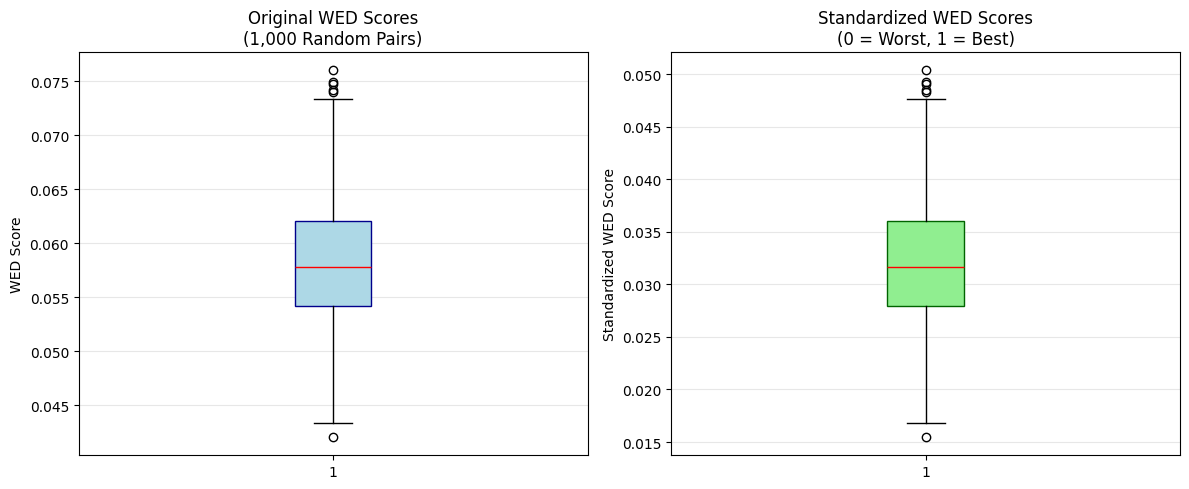

Original WED Stats: Mean=0.058, Median=0.058, Std=0.006

Boxplot Boundaries for Original WED Scores (1,000 Random Pairs):
Minimum (Lower Whisker): 0.0424
Q1 (25th Percentile): 0.0542
Median (50th Percentile): 0.0578
Q3 (75th Percentile): 0.0621
Maximum (Upper Whisker): 0.0739
Outliers: [np.float64(0.0747703149285708), np.float64(0.07497371778303324), np.float64(0.0760090745847469), np.float64(0.07400696716623192), np.float64(0.04204951921620088), np.float64(0.07417110988328064)]
Standardized WED Stats: Mean=0.032, Median=0.032, Std=0.006

Boxplot Boundaries for Standardized WED Scores (1,000 Random Pairs):
Minimum (Lower Whisker): 0.0158
Q1 (25th Percentile): 0.0280
Median (50th Percentile): 0.0317
Q3 (75th Percentile): 0.0361
Maximum (Upper Whisker): 0.0482
Outliers: [np.float64(0.04910906053544436), np.float64(0.04931810477007096), np.float64(0.0503821772028383), np.float64(0.04832454131542761), np.float64(0.015480753232959579), np.float64(0.04849323653234412)]
Project Stats:
       

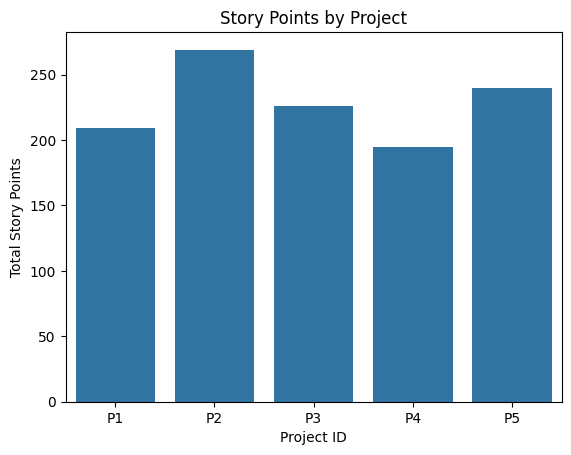

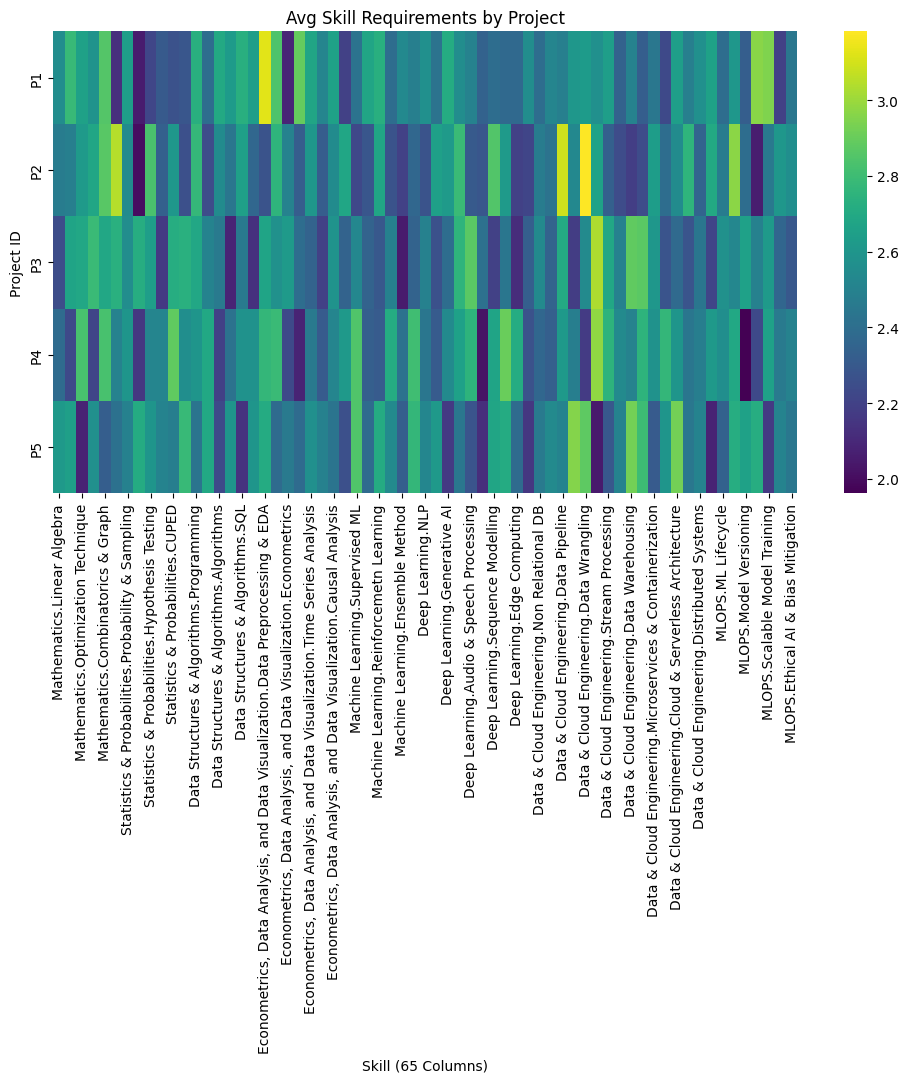


Average Skill Requirements by Project (Tabular Format for LLM Processing):
            Mathematics.Linear Algebra  Mathematics.Differential Equations  Mathematics.Optimization Technique  Mathematics.Calculus  Mathematics.Combinatorics & Graph  Statistics & Probabilities.Statistics  Statistics & Probabilities.Probability & Sampling  Statistics & Probabilities.Bayessian Method  Statistics & Probabilities.Hypothesis Testing  Statistics & Probabilities.A/B Testing  Statistics & Probabilities.CUPED  Data Structures & Algorithms.Complexity Analysis  Data Structures & Algorithms.Programming  Data Structures & Algorithms.Data Structures  Data Structures & Algorithms.Algorithms  Data Structures & Algorithms.Advanced Algorithms  Data Structures & Algorithms.SQL  Data Structures & Algorithms.Shell / Bash Scripting  Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA  Econometrics, Data Analysis, and Data Visualization.Data Viz & Storytelling  Econometrics, Data Analysis,

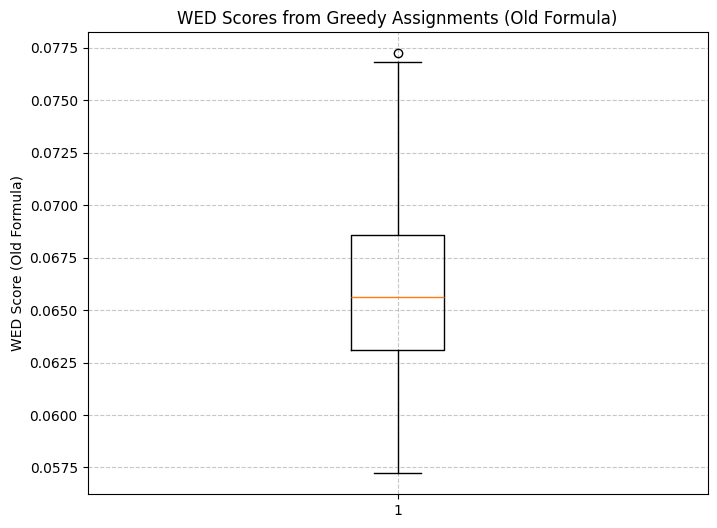

Original WED Scores (Old Formula): Mean=0.066, Median=0.066, Std=0.004

Boxplot Boundaries for Original WED Scores (Greedy Assignments):
Minimum (Lower Whisker): 0.0572
Q1 (25th Percentile): 0.0631
Median (50th Percentile): 0.0656
Q3 (75th Percentile): 0.0686
Maximum (Upper Whisker): 0.0769
Outliers: [np.float64(0.07722663748881113)]


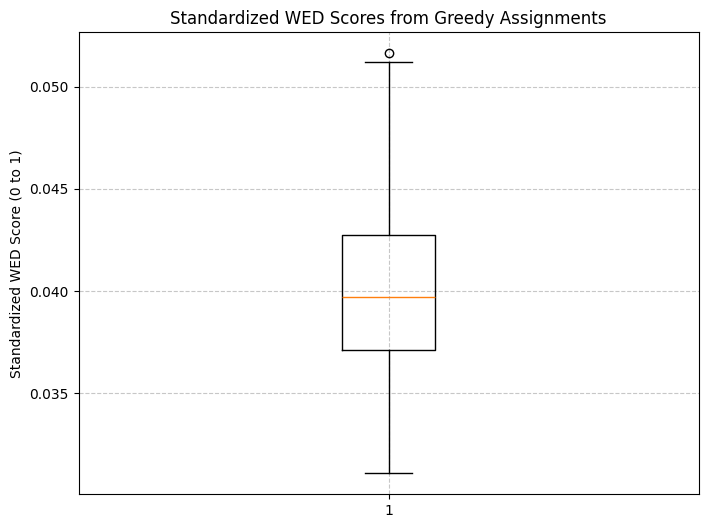

Standardized WED Scores: Mean=0.040, Median=0.040, Std=0.004

Boxplot Boundaries for Standardized WED Scores (Greedy Assignments):
Minimum (Lower Whisker): 0.0311
Q1 (25th Percentile): 0.0371
Median (50th Percentile): 0.0397
Q3 (75th Percentile): 0.0428
Maximum (Upper Whisker): 0.0513
Outliers: [np.float64(0.05163350922599258)]


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Paths
EMP_PATH = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
TASK_PATH = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'

# Load
emp_df = pd.read_csv(EMP_PATH, index_col='employee_id').fillna(0).drop(columns=['No', 'Role'], errors='ignore')
task_df = pd.read_csv(TASK_PATH, index_col='task_id').fillna(0)
skill_cols = [col for col in task_df.columns if col not in ['project_id', 'story_points']]  # 65 skills
assert len(skill_cols) == 65, "Skill column count mismatch"
assert emp_df.shape[0] == 109 and task_df.shape[0] == 300, "Row count mismatch"

# 1. Feasibility (with visualization)
total_sp = task_df['story_points'].sum()
capacity = 109 * 20
ratio = total_sp/capacity

# New visualization for feasibility metrics
plt.figure(figsize=(8, 4))
bars = plt.bar(['Total Story Points', 'Capacity'], [total_sp, capacity], color=['#1f77b4', '#ff7f0e'])
plt.title(f"Feasibility Check\n(Utilization Ratio: {ratio:.2%})")
plt.ylabel("Points")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Total Story Points: {total_sp}, Capacity: {capacity}, Ratio: {total_sp/capacity:.2f}")

# 2. Story Points (Fibonacci Sequence) - with adjusted spacing
fibonacci_sp = [1, 2, 3, 5, 8, 13, 20]
sp_counts = task_df['story_points'].value_counts().reindex(fibonacci_sp, fill_value=0)

plt.figure(figsize=(10, 6))
plt.bar(range(len(sp_counts)), sp_counts.values, width=0.8,
        edgecolor='white', linewidth=1.5)
plt.title("Story Points Distribution (Fibonacci Sequence, 300 Tasks)")
plt.xlabel("Story Points (Fibonacci)")
plt.ylabel("Task Count")

# Add value labels on top of bars
for i, v in enumerate(sp_counts.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.xticks(range(len(sp_counts)), sp_counts.index)
plt.ylim(0, sp_counts.max() * 1.15)  # Add headroom for labels
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Fibonacci Story Points Counts:\n", sp_counts)

# Binning for additional insight
bins = pd.cut(task_df['story_points'], bins=[0, 5, 10, 15, 20], include_lowest=True)
print("Story Points Bins:\n", bins.value_counts().sort_index())

# 3. Skills
emp_skills = emp_df[skill_cols]
task_skills = task_df[skill_cols]
emp_sparsity = (emp_skills == 0).mean().mean()
task_sparsity = (task_skills == 0).mean().mean()
print(f"Employee Sparsity: {emp_sparsity:.2%}, Task Sparsity: {task_sparsity:.2%}")
print(f"Mean Employee Skill (non-zero): {emp_skills[emp_skills > 0].mean().mean():.2f}")
print(f"Mean Task Skill (non-zero): {task_skills[task_skills > 0].mean().mean():.2f}")

# WED calculation (with standardization and visualization)
def calculate_wed(emp, task, alpha=0.05):
    weights = 1 / (1 + alpha * np.maximum(0, emp - task))
    wed = np.sqrt(np.sum(weights * (emp - task) ** 2))
    return 1 / (1 + wed)  # Convert distance to similarity score

# Theoretical worst and best WED scores
alpha = 0.05  # Same as in calculate_wed function
weights_worst = 1 / (1 + alpha * 5)  # emp=0, task=5, max difference
d_max = np.sqrt(np.sum(weights_worst * (0 - 5) ** 2 * 65))  # Max distance
wed_worst = 1 / (1 + d_max)  # Theoretical worst WED score
wed_best = 1 / (1 + 0)  # Theoretical best WED score (distance = 0)

print(f"Theoretical WED Range: Worst={wed_worst:.4f}, Best={wed_best:.4f}")

# Sample WED (1,000 pairs)
np.random.seed(42)
emp_idx = np.random.choice(109, 1000, replace=True)
task_idx = np.random.choice(300, 1000, replace=True)
wed_sample = [calculate_wed(emp_skills.iloc[i], task_skills.iloc[j])
              for i, j in zip(emp_idx, task_idx)]

# Standardize WED scores
wed_sample_std = [(wed - wed_worst) / (wed_best - wed_worst) for wed in wed_sample]

# Compute boxplot boundaries for 1,000 random pairs
def compute_boxplot_boundaries(data, label):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_whisker = max(min(data), q1 - 1.5 * iqr)
    upper_whisker = min(max(data), q3 + 1.5 * iqr)
    outliers = [x for x in data if x < lower_whisker or x > upper_whisker]
    print(f"\nBoxplot Boundaries for {label}:")
    print(f"Minimum (Lower Whisker): {lower_whisker:.4f}")
    print(f"Q1 (25th Percentile): {q1:.4f}")
    print(f"Median (50th Percentile): {np.median(data):.4f}")
    print(f"Q3 (75th Percentile): {q3:.4f}")
    print(f"Maximum (Upper Whisker): {upper_whisker:.4f}")
    print(f"Outliers: {outliers}")

# Visualization for 1,000 random pairs
plt.figure(figsize=(12, 5))

# Original WED scores
plt.subplot(1, 2, 1)
plt.boxplot(wed_sample, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='darkblue'),
            medianprops=dict(color='red'))
plt.title("Original WED Scores\n(1,000 Random Pairs)")
plt.ylabel("WED Score")
plt.grid(axis='y', alpha=0.3)

# Standardized WED scores
plt.subplot(1, 2, 2)
plt.boxplot(wed_sample_std, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            medianprops=dict(color='red'))
plt.title("Standardized WED Scores\n(0 = Worst, 1 = Best)")
plt.ylabel("Standardized WED Score")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics and boundaries for 1,000 random pairs
print(f"Original WED Stats: Mean={np.mean(wed_sample):.3f}, Median={np.median(wed_sample):.3f}, Std={np.std(wed_sample):.3f}")
compute_boxplot_boundaries(wed_sample, "Original WED Scores (1,000 Random Pairs)")
print(f"Standardized WED Stats: Mean={np.mean(wed_sample_std):.3f}, Median={np.median(wed_sample_std):.3f}, Std={np.std(wed_sample_std):.3f}")
compute_boxplot_boundaries(wed_sample_std, "Standardized WED Scores (1,000 Random Pairs)")

# 4. Projects
proj_stats = task_df.groupby('project_id').agg(total_sp=('story_points', 'sum'), task_count=('story_points', 'count'))
print("Project Stats:\n", proj_stats)
sns.barplot(x=proj_stats.index, y=proj_stats['total_sp'])
plt.title("Story Points by Project")
plt.xlabel("Project ID")
plt.ylabel("Total Story Points")
plt.show()
proj_skills = task_df.groupby('project_id')[skill_cols].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(proj_skills, cmap='viridis')
plt.title("Avg Skill Requirements by Project")
plt.xlabel("Skill (65 Columns)")
plt.ylabel("Project ID")
plt.show()

# Tabular output for avg skill requirements by project
print("\nAverage Skill Requirements by Project (Tabular Format for LLM Processing):")
print(proj_skills.to_string())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns

# 5. Greedy Approach with Old WED Formula and Standardization
# WED calculation (old method, without global_max normalization)
def calculate_wed_old(emp, task, alpha=0.05):
    weights = 1 / (1 + alpha * np.maximum(0, emp - task))
    wed = np.sqrt(np.sum(weights * (emp - task) ** 2))
    return 1 / (1 + wed)  # Old normalization method

# Initialize data structures
assignments = {}  # emp_idx -> list of (task_id, project_id, sp, wed_score)
workload = np.zeros(109)

# Initialize assignments dictionary for all employees
for emp_idx in range(109):
    assignments[emp_idx] = []

# Run Greedy with old WED calculation
np.random.seed(42)
for task_idx in np.random.permutation(300):
    task = task_skills.iloc[task_idx]
    sp = task_df['story_points'].iloc[task_idx]
    project_id = task_df['project_id'].iloc[task_idx]
    task_id = task_df.index[task_idx]
    best_emp, best_wed = None, -1
    for emp_idx in range(109):
        if workload[emp_idx] + sp <= 20:
            wed = calculate_wed_old(emp_skills.iloc[emp_idx], task)
            if wed > best_wed:
                best_wed, best_emp = wed, emp_idx
    if best_emp is not None:
        assignments[best_emp].append((task_id, project_id, sp, best_wed))
        workload[best_emp] += sp

# Step 1: Save assignments as CSV
data = []
for emp_idx, tasks in assignments.items():
    employee_id = emp_df.index[emp_idx]  # e.g., 'Talent 1'
    projects = [proj for _, proj, _, _ in tasks] if tasks else []
    assigned_tasks = [task for task, _, _, _ in tasks] if tasks else []
    sum_sp = sum(sp for _, _, sp, _ in tasks) if tasks else 0
    wasted_sp = 20 - sum_sp
    similarity_scores = [wed for _, _, _, wed in tasks] if tasks else []
    data.append([employee_id, projects, assigned_tasks, sum_sp, wasted_sp, similarity_scores])

df = pd.DataFrame(data, columns=['employee', 'project', 'assigned_task', 'sum_sp', 'wasted_sp', 'similarity_score'])
df.to_csv('greedy_old_method.csv', index=False)

# Step 2: Collect WED scores
weds_old = [wed for emp_tasks in assignments.values() for _, _, _, wed in emp_tasks]

# Step 3: Standardize the WED scores
# Compute theoretical worst and best scores
alpha = 0.05
# Theoretical worst: emp=[0,0,...,0], task=[5,5,...,5], 65 skills
weights_worst = 1 / (1 + alpha * 5)  # Since emp=0, task=5, max difference
d_max = np.sqrt(np.sum(weights_worst * (0 - 5) ** 2) * 65)  # Max distance
wed_old_worst = 1 / (1 + d_max)  # Theoretical worst WED score
wed_old_best = 1 / (1 + 0)  # Theoretical best WED score (distance = 0)
print(f"\nTheoretical Worst WED (Old Formula): {wed_old_worst:.6f}")
print(f"Theoretical Best WED (Old Formula): {wed_old_best:.6f}")

# Standardize: map wed_old_worst to 0, wed_old_best to 1
weds_standardized = [(wed - wed_old_worst) / (wed_old_best - wed_old_worst) for wed in weds_old]

# Step 4: Visualizations for WED Scores
# Boxplot 1: Original WED scores (old formula)
plt.figure(figsize=(8, 6))
plt.boxplot(weds_old)
plt.title("WED Scores from Greedy Assignments (Old Formula)")
plt.ylabel("WED Score (Old Formula)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(f"Original WED Scores (Old Formula): Mean={np.mean(weds_old):.3f}, Median={np.median(weds_old):.3f}, Std={np.std(weds_old):.3f}")
# Assuming compute_boxplot_boundaries is defined elsewhere
# compute_boxplot_boundaries(weds_old, "Original WED Scores (Greedy Assignments)")

# Boxplot 2: Standardized WED scores
plt.figure(figsize=(8, 6))
plt.boxplot(weds_standardized)
plt.title("Standardized WED Scores from Greedy Assignments")
plt.ylabel("Standardized WED Score (0 to 1)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(f"Standardized WED Scores: Mean={np.mean(weds_standardized):.3f}, Median={np.median(weds_standardized):.3f}, Std={np.std(weds_standardized):.3f}")
# compute_boxplot_boundaries(weds_standardized, "Standardized WED Scores (Greedy Assignments)")

# Step 5: Visualize Story Points Distribution and Standard Deviation for Greedy Approach
# Extract employee names and story points
employee_list = df['employee'].tolist()  # e.g., ['Talent 1', 'Talent 2', ..., 'Talent 109']
story_points_greedy = df['sum_sp'].tolist()

# Create table for story points allocation
story_points_greedy_df = pd.DataFrame({
    'Greedy': story_points_greedy
}, index=employee_list)
print("\nTabel Alokasi Story Points per Karyawan - Pendekatan Greedy:")
print(story_points_greedy_df)

# Visualization: Bar Chart of Story Points Allocation per Employee for Greedy Approach
plt.figure(figsize=(14, 6))
plt.bar(employee_list, story_points_greedy, color='skyblue')
plt.title("Distribusi Story Points per Karyawan - Pendekatan Greedy")
plt.xlabel("Employee")
plt.ylabel("Total Story Points")
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compute standard deviation of story points allocation for Greedy Approach
std_dev_greedy = np.std(story_points_greedy)

# Create table for standard deviation
std_dev_greedy_df = pd.DataFrame({
    'Standard Deviation': [std_dev_greedy]
}, index=['Greedy'])
print("\nTabel Standar Deviasi Beban Kerja (Story Points) - Pendekatan Greedy:")
print(std_dev_greedy_df)

# Visualization: Bar Chart of Standard Deviation for Greedy Approach
plt.figure(figsize=(6, 4))
plt.bar(['Greedy'], [std_dev_greedy], color='skyblue')
plt.title("Standar Deviasi Beban Kerja (Story Points) - Pendekatan Greedy")
plt.ylabel("Standar Deviasi (Story Points)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Standar Deviasi Beban Kerja (Greedy): {std_dev_greedy:.2f}")

## Employee Dataset

Mounted at /content/drive


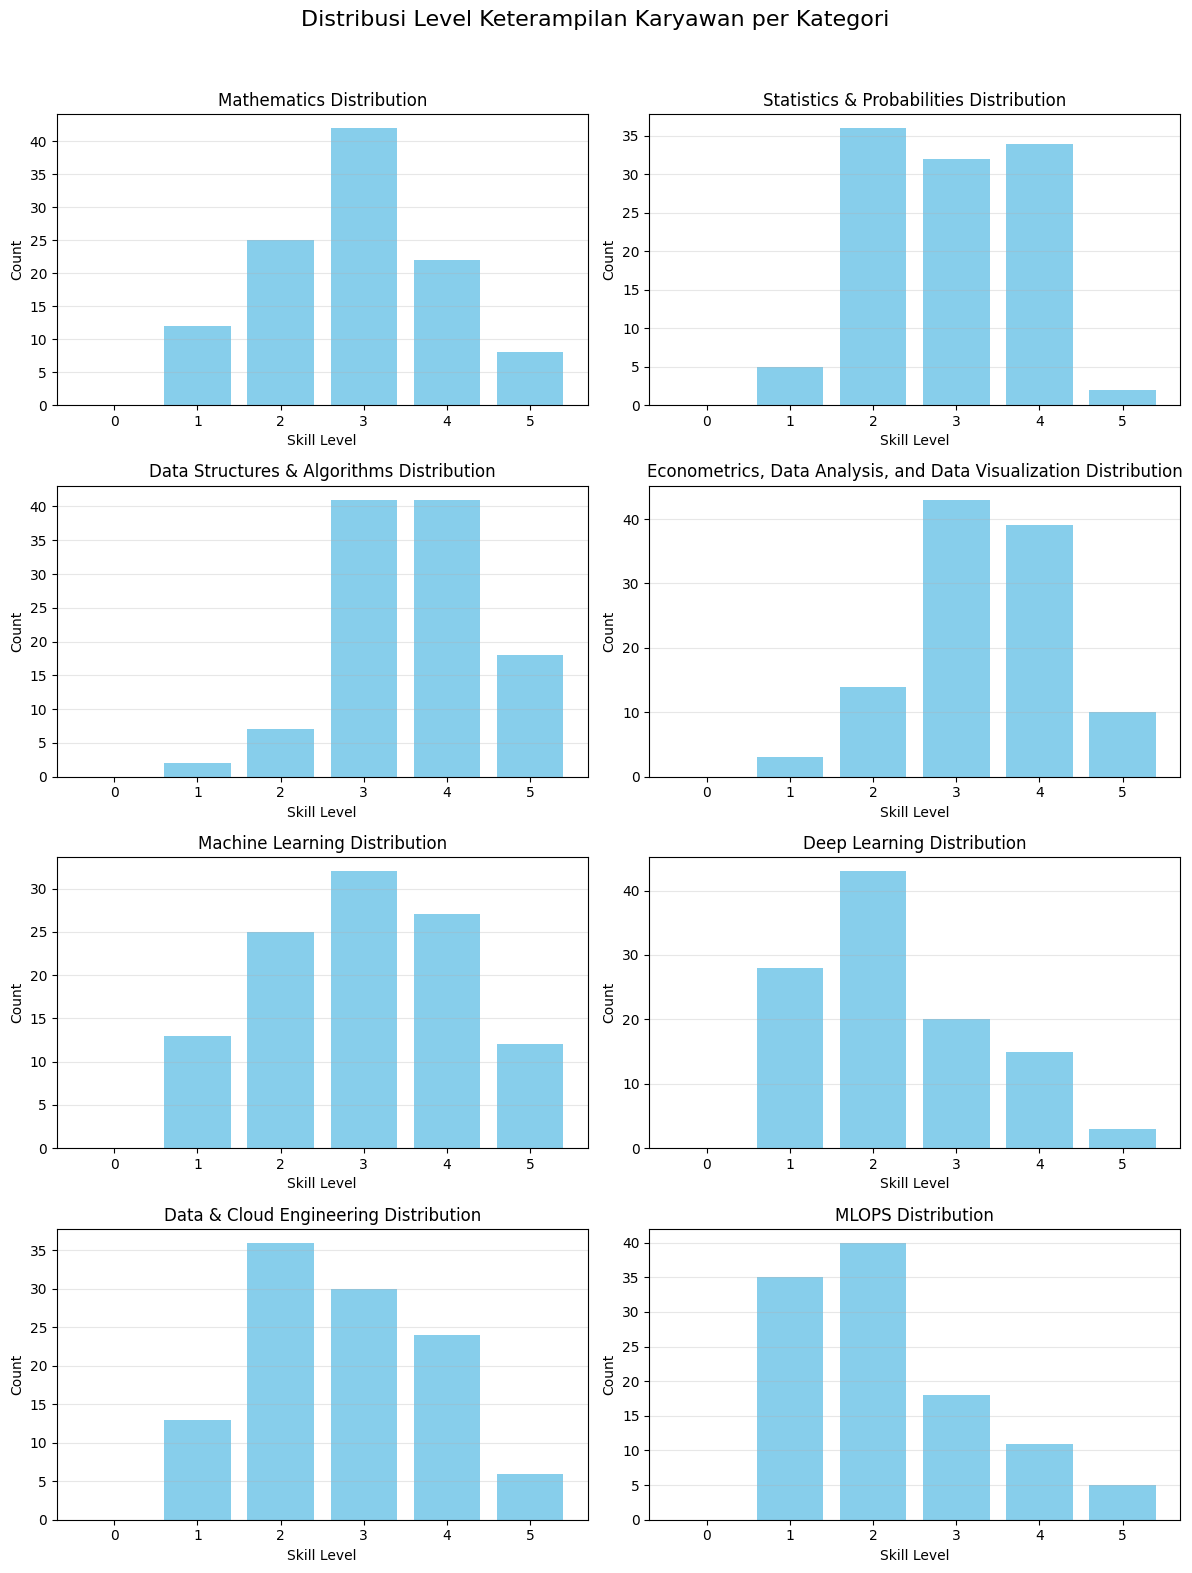

Tabel Distribusi Level Keterampilan Karyawan per Kategori:
                                                    Level 0  Level 1  Level 2  \
Mathematics                                               0       12       25   
Statistics & Probabilities                                0        5       36   
Data Structures & Algorithms                              0        2        7   
Econometrics, Data Analysis, and Data Visualiza...        0        3       14   
Machine Learning                                          0       13       25   
Deep Learning                                             0       28       43   
Data & Cloud Engineering                                  0       13       36   
MLOPS                                                     0       35       40   

                                                    Level 3  Level 4  Level 5  
Mathematics                                              42       22        8  
Statistics & Probabilities                         

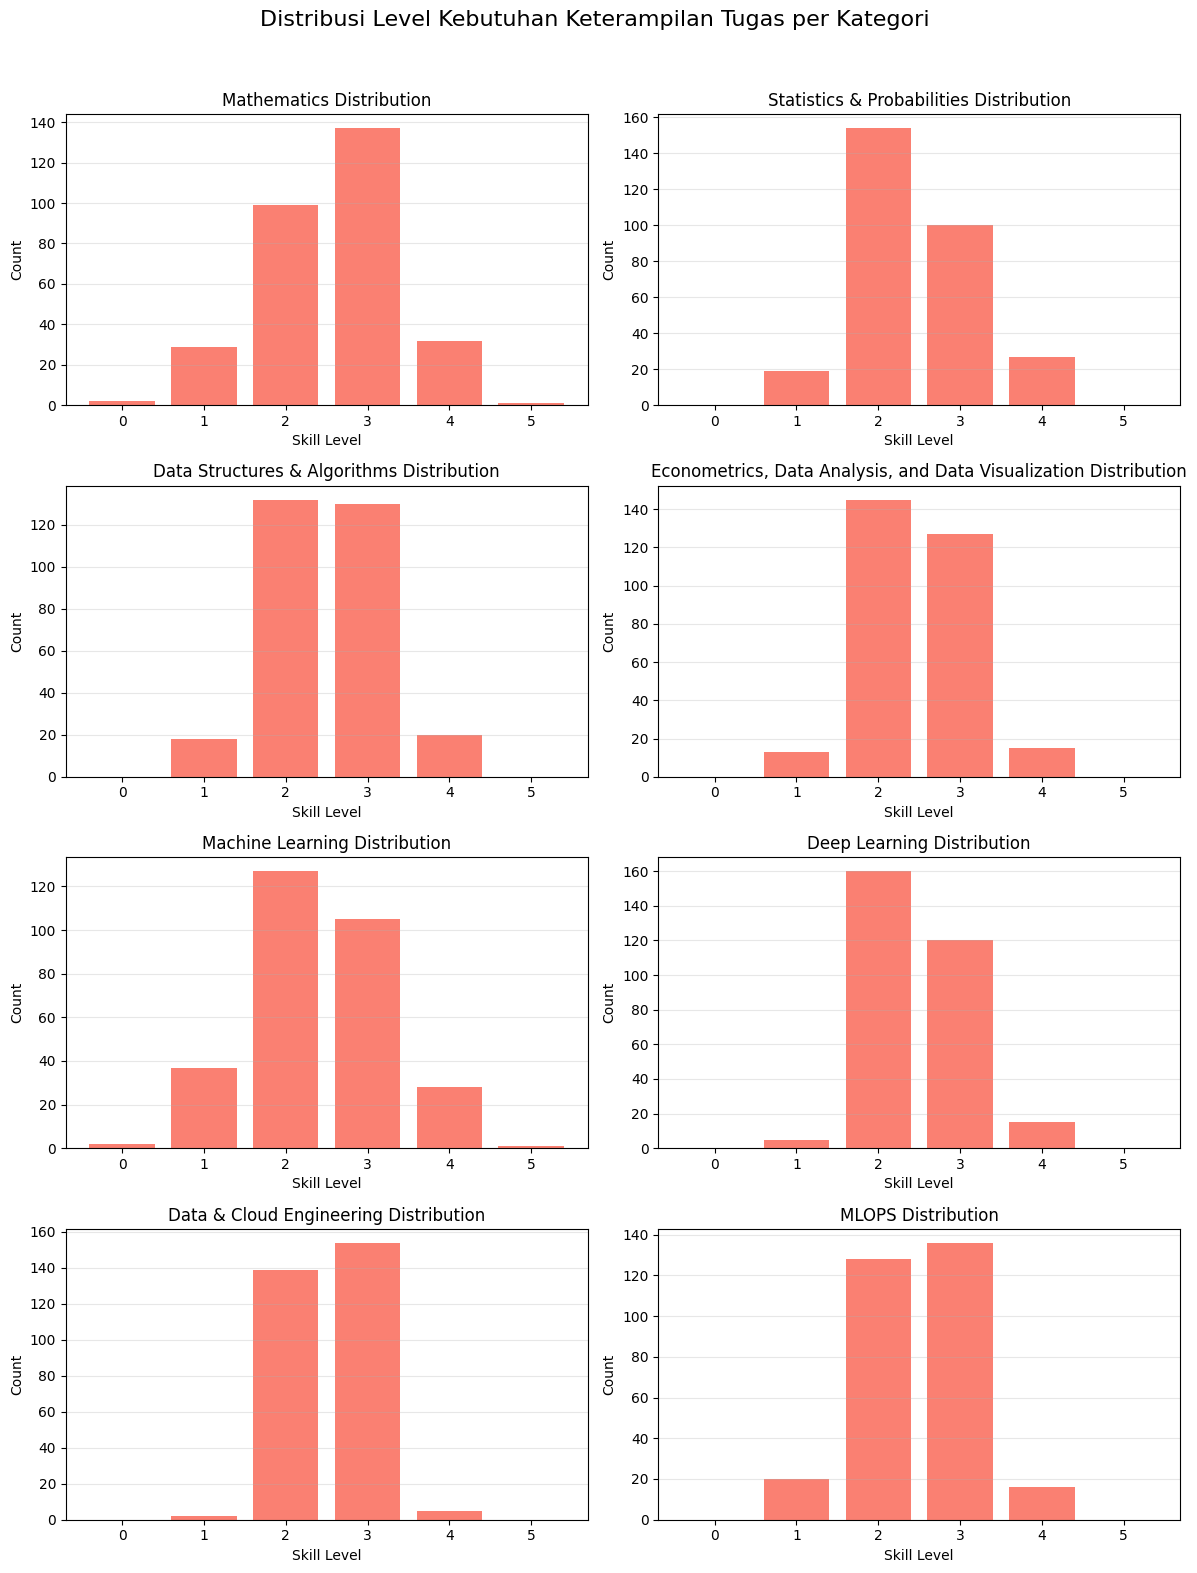

Tabel Distribusi Level Kebutuhan Keterampilan Tugas per Kategori:
                                                    Level 0  Level 1  Level 2  \
Mathematics                                               2       29       99   
Statistics & Probabilities                                0       19      154   
Data Structures & Algorithms                              0       18      132   
Econometrics, Data Analysis, and Data Visualiza...        0       13      145   
Machine Learning                                          2       37      127   
Deep Learning                                             0        5      160   
Data & Cloud Engineering                                  0        2      139   
MLOPS                                                     0       20      128   

                                                    Level 3  Level 4  Level 5  
Mathematics                                             137       32        1  
Statistics & Probabilities                  

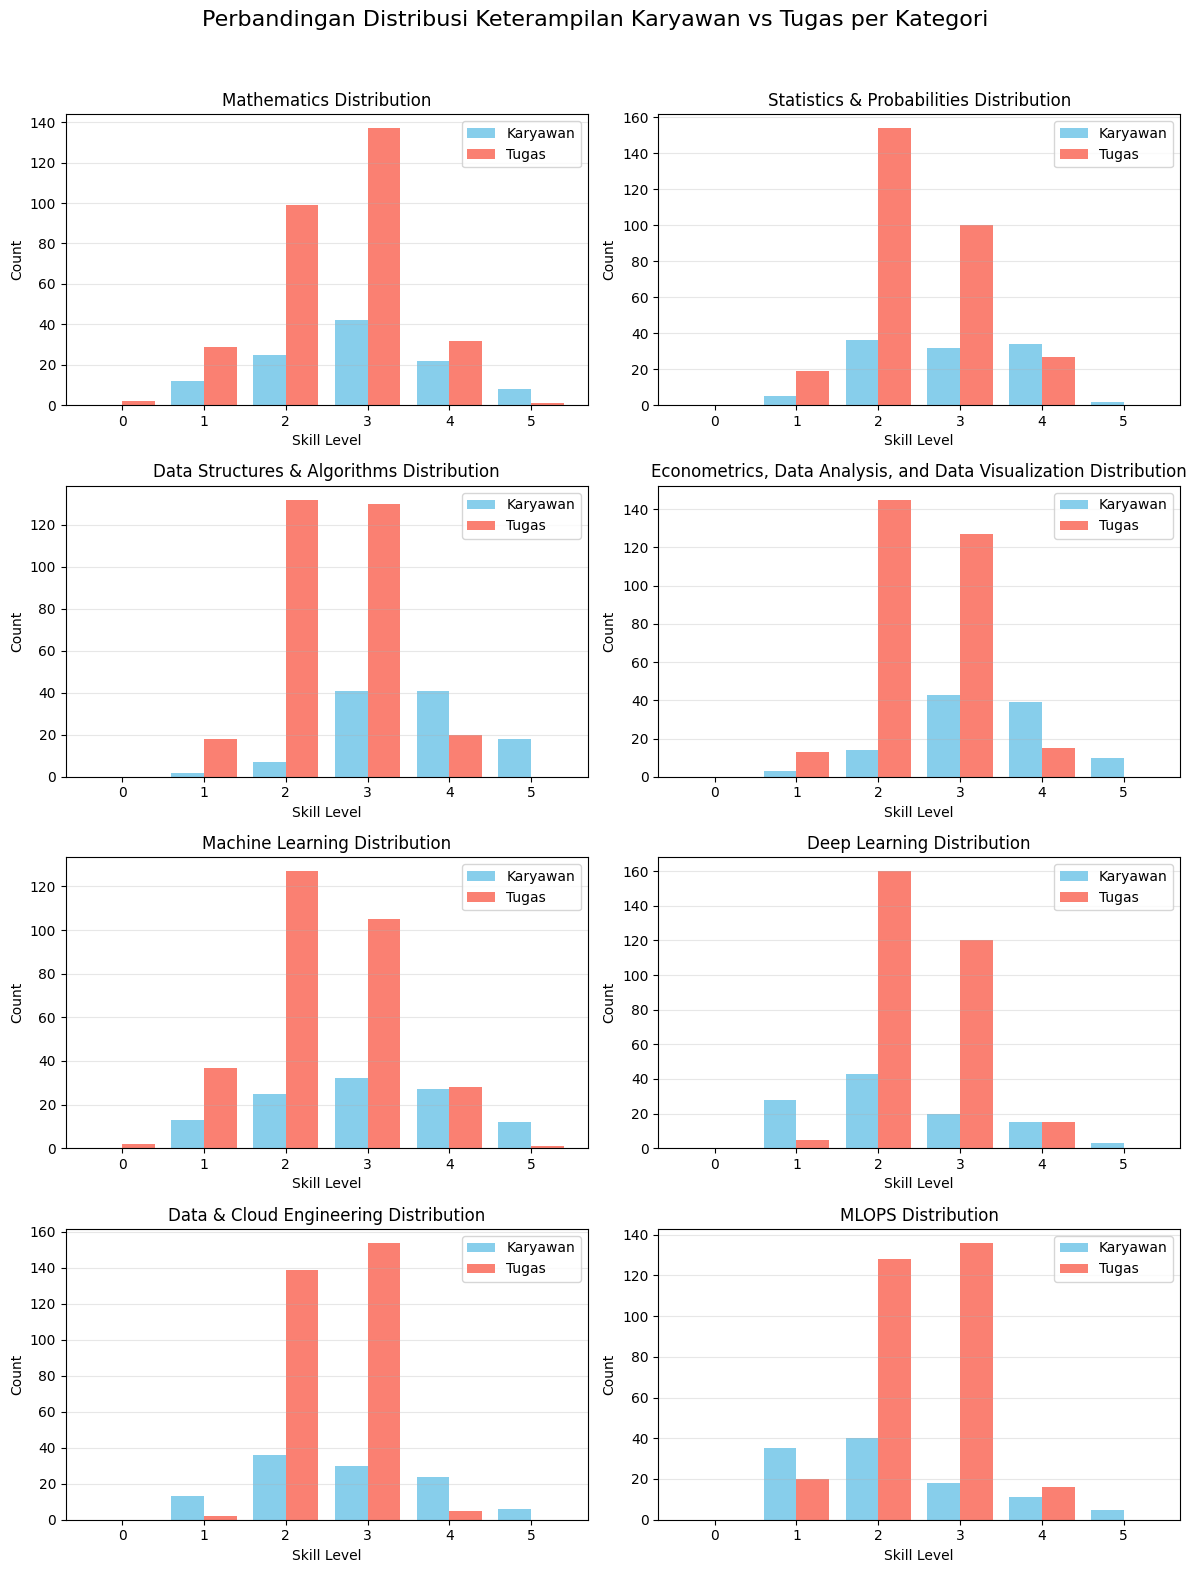

Tabel Perbandingan Distribusi Keterampilan Karyawan vs Tugas per Kategori:
                                                    Karyawan Level 0  \
Mathematics                                                        0   
Statistics & Probabilities                                         0   
Data Structures & Algorithms                                       0   
Econometrics, Data Analysis, and Data Visualiza...                 0   
Machine Learning                                                   0   
Deep Learning                                                      0   
Data & Cloud Engineering                                           0   
MLOPS                                                              0   

                                                    Karyawan Level 1  \
Mathematics                                                       12   
Statistics & Probabilities                                         5   
Data Structures & Algorithms                                

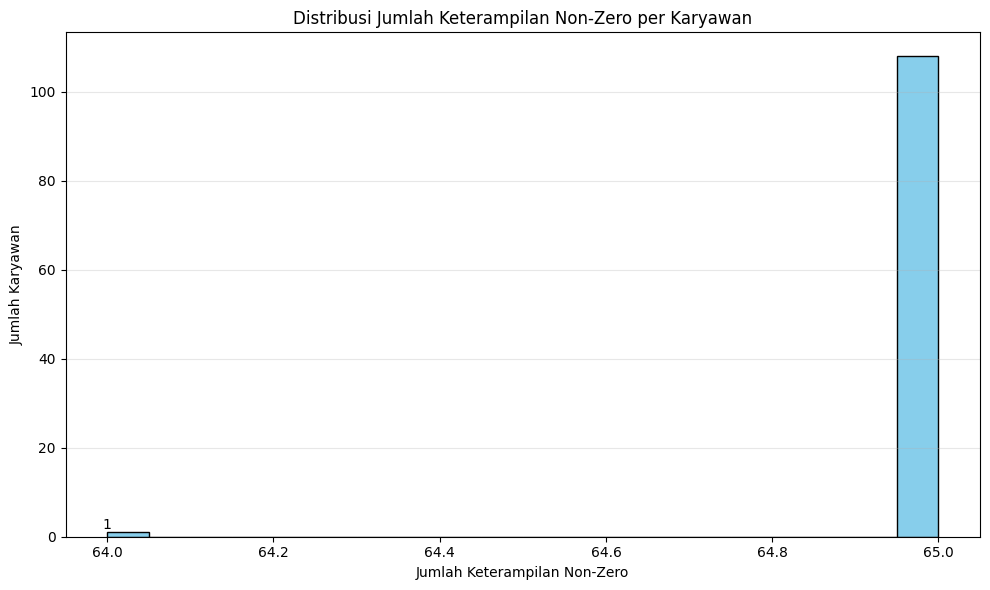

Tabel Distribusi Jumlah Keterampilan Non-Zero per Karyawan:
   Jumlah Keterampilan Non-Zero  Jumlah Karyawan
0                            64                1
1                            65              108


Jumlah karyawan dengan 64 keterampilan non-zero: 1
Jumlah karyawan dengan 65 keterampilan non-zero: 108


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Paths
EMP_PATH = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
TASK_PATH = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'

# Load data
emp_df = pd.read_csv(EMP_PATH, index_col='employee_id').fillna(0).drop(columns=['No', 'Role'], errors='ignore')
task_df = pd.read_csv(TASK_PATH, index_col='task_id').fillna(0)

# Define skill columns
skill_cols = [col for col in task_df.columns if col not in ['project_id', 'story_points']]  # 65 skills
assert len(skill_cols) == 65, "Skill column count mismatch"
assert emp_df.shape[0] == 109 and task_df.shape[0] == 300, "Row count mismatch"

# Extract skill data
emp_skills = emp_df[skill_cols]
task_skills = task_df[skill_cols]

# Define 8 categories based on prefixes in skill column names
categories = {
    'Mathematics': [col for col in skill_cols if col.startswith('Mathematics')],
    'Statistics & Probabilities': [col for col in skill_cols if col.startswith('Statistics & Probabilities')],
    'Data Structures & Algorithms': [col for col in skill_cols if col.startswith('Data Structures & Algorithms')],
    'Econometrics, Data Analysis, and Data Visualization': [col for col in skill_cols if col.startswith('Econometrics, Data Analysis, and Data Visualization')],
    'Machine Learning': [col for col in skill_cols if col.startswith('Machine Learning')],
    'Deep Learning': [col for col in skill_cols if col.startswith('Deep Learning')],
    'Data & Cloud Engineering': [col for col in skill_cols if col.startswith('Data & Cloud Engineering')],
    'MLOPS': [col for col in skill_cols if col.startswith('MLOPS')]
}

# 1. Distribusi Skor Keterampilan Karyawan per Kategori
# Create table for employee skill distribution
emp_skill_dist = {category: {level: 0 for level in range(6)} for category in categories.keys()}

# Create subplots for employees (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle("Distribusi Level Keterampilan Karyawan per Kategori", fontsize=16)

for idx, (category, cols) in enumerate(categories.items()):
    row = idx // 2
    col = idx % 2
    # Calculate mean skill score per employee for this category
    emp_scores = emp_skills[cols].mean(axis=1)
    # Round scores to nearest integer (0-5) for discrete levels
    emp_scores_rounded = np.round(emp_scores).astype(int)
    # Plot histogram
    counts, _ = np.histogram(emp_scores_rounded, bins=[0, 1, 2, 3, 4, 5, 6])
    for level, count in enumerate(counts):
        emp_skill_dist[category][level] = count
    axes[row, col].hist(emp_scores_rounded, bins=[0, 1, 2, 3, 4, 5, 6], align='left', rwidth=0.8, color='skyblue')
    axes[row, col].set_title(f"{category} Distribution")
    axes[row, col].set_xlabel("Skill Level")
    axes[row, col].set_ylabel("Count")
    axes[row, col].set_xticks([0, 1, 2, 3, 4, 5])
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Convert employee skill distribution to DataFrame
emp_skill_dist_df = pd.DataFrame(emp_skill_dist).T
emp_skill_dist_df.columns = [f"Level {i}" for i in range(6)]
print("Tabel Distribusi Level Keterampilan Karyawan per Kategori:")
print(emp_skill_dist_df)
print("\n")

# 2. Distribusi Skor Keterampilan Tugas per Kategori
# Create table for task skill distribution
task_skill_dist = {category: {level: 0 for level in range(6)} for category in categories.keys()}

# Create subplots for tasks (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle("Distribusi Level Kebutuhan Keterampilan Tugas per Kategori", fontsize=16)

for idx, (category, cols) in enumerate(categories.items()):
    row = idx // 2
    col = idx % 2
    # Calculate mean skill requirement per task for this category
    task_scores = task_skills[cols].mean(axis=1)
    # Round scores to nearest integer (0-5) for discrete levels
    task_scores_rounded = np.round(task_scores).astype(int)
    # Plot histogram
    counts, _ = np.histogram(task_scores_rounded, bins=[0, 1, 2, 3, 4, 5, 6])
    for level, count in enumerate(counts):
        task_skill_dist[category][level] = count
    axes[row, col].hist(task_scores_rounded, bins=[0, 1, 2, 3, 4, 5, 6], align='left', rwidth=0.8, color='salmon')
    axes[row, col].set_title(f"{category} Distribution")
    axes[row, col].set_xlabel("Skill Level")
    axes[row, col].set_ylabel("Count")
    axes[row, col].set_xticks([0, 1, 2, 3, 4, 5])
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Convert task skill distribution to DataFrame
task_skill_dist_df = pd.DataFrame(task_skill_dist).T
task_skill_dist_df.columns = [f"Level {i}" for i in range(6)]
print("Tabel Distribusi Level Kebutuhan Keterampilan Tugas per Kategori:")
print(task_skill_dist_df)
print("\n")

# 3. Perbandingan Distribusi Karyawan vs Tugas (Side-by-Side Histogram)
# Create table for comparison
comparison_dist = {}
for category in categories.keys():
    comparison_dist[category] = {
        f"Karyawan Level {i}": emp_skill_dist[category][i] for i in range(6)
    }
    comparison_dist[category].update({
        f"Tugas Level {i}": task_skill_dist[category][i] for i in range(6)
    })

# Create subplots for side-by-side comparison (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle("Perbandingan Distribusi Keterampilan Karyawan vs Tugas per Kategori", fontsize=16)

for idx, (category, cols) in enumerate(categories.items()):
    row = idx // 2
    col = idx % 2
    # Employee scores
    emp_scores = emp_skills[cols].mean(axis=1)
    emp_scores_rounded = np.round(emp_scores).astype(int)
    # Task scores
    task_scores = task_skills[cols].mean(axis=1)
    task_scores_rounded = np.round(task_scores).astype(int)
    # Plot side-by-side histogram
    axes[row, col].hist([emp_scores_rounded, task_scores_rounded], bins=[0, 1, 2, 3, 4, 5, 6],
                        align='left', rwidth=0.8, label=['Karyawan', 'Tugas'], color=['skyblue', 'salmon'])
    axes[row, col].set_title(f"{category} Distribution")
    axes[row, col].set_xlabel("Skill Level")
    axes[row, col].set_ylabel("Count")
    axes[row, col].set_xticks([0, 1, 2, 3, 4, 5])
    axes[row, col].legend()
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Convert comparison distribution to DataFrame
comparison_dist_df = pd.DataFrame(comparison_dist).T
print("Tabel Perbandingan Distribusi Keterampilan Karyawan vs Tugas per Kategori:")
print(comparison_dist_df)
print("\n")

# 4. Histogram Jumlah Keterampilan Non-Zero (dengan Label untuk 64 dan 65)
num_nonzero_skills = (emp_skills > 0).sum(axis=1)
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(num_nonzero_skills, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribusi Jumlah Keterampilan Non-Zero per Karyawan")
plt.xlabel("Jumlah Keterampilan Non-Zero")
plt.ylabel("Jumlah Karyawan")
plt.grid(axis='y', alpha=0.3)

# Add labels for 64 and 65 non-zero skills
count_64 = sum(num_nonzero_skills == 64)
count_65 = sum(num_nonzero_skills == 65)
for i in range(len(bins)-1):
    if bins[i] <= 64 < bins[i+1]:
        plt.text(64, counts[i], f"{int(counts[i])}", ha='center', va='bottom')
    if bins[i] <= 65 < bins[i+1]:
        plt.text(65, counts[i], f"{int(counts[i])}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create table for non-zero skills distribution
nonzero_skills_dist = pd.Series(num_nonzero_skills).value_counts().sort_index()
nonzero_skills_dist_df = pd.DataFrame({
    'Jumlah Keterampilan Non-Zero': nonzero_skills_dist.index,
    'Jumlah Karyawan': nonzero_skills_dist.values
})
print("Tabel Distribusi Jumlah Keterampilan Non-Zero per Karyawan:")
print(nonzero_skills_dist_df)
print("\n")
print(f"Jumlah karyawan dengan 64 keterampilan non-zero: {count_64}")
print(f"Jumlah karyawan dengan 65 keterampilan non-zero: {count_65}")

# MOO Approach with Old Equation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load datasets
path_obj1 = '/content/drive/MyDrive/Skripsi/Resources/Output/result_obj1.csv'
path_obj2 = '/content/drive/MyDrive/Skripsi/Resources/Output/result_obj2.csv'
path_obj3 = '/content/drive/MyDrive/Skripsi/Resources/Output/result_obj3.csv'
path_moo = '/content/drive/MyDrive/Skripsi/Resources/Output/result_moo.csv'

result_obj1 = pd.read_csv(path_obj1)
result_obj2 = pd.read_csv(path_obj2)
result_obj3 = pd.read_csv(path_obj3)
result_moo = pd.read_csv(path_moo)

# Extract similarity scores for all approaches
approaches = {
    'Objective 1': result_obj1,
    'Objective 2': result_obj2,
    'Objective 3': result_obj3,
    'MOO': result_moo
}

weds_standardized_all = {}
weds_old_all = {}
weds_raw_all = {}  # Untuk simpen WED asli

# Compute theoretical worst and best WED scores
alpha = 0.5  # As defined in your original custom_we function
# Theoretical worst: emp=[0,0,...,0], task=[5,5,...,5], 65 skills
weights_worst = 1 / (1 + alpha * 5)  # Since emp=0, task=5, max difference
d_max = np.sqrt(np.sum(weights_worst * (0 - 5) ** 2) * 65)  # Max distance (WED_worst)
wed_raw_worst = d_max  # WED terburuk asli
wed_raw_best = 0  # WED terbaik asli (exact match)

# Hitung similarity score teoritis dari WED_worst dan WED_best
wed_old_worst = 1 / (1 + wed_raw_worst)  # Similarity score teoritis terburuk
wed_old_best = 1 / (1 + wed_raw_best)  # Similarity score teoritis terbaik

print(f"Theoretical Worst WED (Raw): {wed_raw_worst:.6f}")
print(f"Theoretical Best WED (Raw): {wed_raw_best:.6f}")
print(f"Theoretical Worst Similarity Score (Old Formula): {wed_old_worst:.6f}")
print(f"Theoretical Best Similarity Score (Old Formula): {wed_old_best:.6f}")

# Standardize WED scores for each approach and collect statistics
weds_stats = {}
for approach_name, result_df in approaches.items():
    weds_old = []  # Similarity scores mentah (1 / (1 + WED))
    weds_raw = []  # WED asli

    # Ambil similarity scores dari CSV dan balikkan ke WED
    for scores_str in result_df['similarity_score']:
        scores = ast.literal_eval(scores_str)
        weds_old.extend(scores)
        # Balikkan ke WED: WED = (1 / similarity_score) - 1
        weds_raw.extend([(1 / score) - 1 for score in scores])

    # Standardize WED ke skala 0-1: 0 = WED_worst, 1 = WED_best
    weds_standardized = [(wed_raw_worst - wed) / (wed_raw_worst - wed_raw_best) for wed in weds_raw]

    weds_old_all[approach_name] = weds_old
    weds_raw_all[approach_name] = weds_raw
    weds_standardized_all[approach_name] = weds_standardized

    # Compute statistics for standardized scores
    q1 = np.percentile(weds_standardized, 25)
    q3 = np.percentile(weds_standardized, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [x for x in weds_standardized if x < lower_bound or x > upper_bound]

    weds_stats[approach_name] = {
        'Mean': np.mean(weds_standardized),
        'Median': np.median(weds_standardized),
        'Minimum': np.min(weds_standardized),
        'Q1': q1,
        'Q3': q3,
        'Maximum': np.max(weds_standardized),
        'Outliers': outliers if outliers else 'None'
    }

    print(f"\n{approach_name} - Original Similarity Scores (Old Formula): Mean={np.mean(weds_old):.3f}, Median={np.median(weds_old):.3f}, Std={np.std(weds_old):.3f}")
    print(f"{approach_name} - Raw WED Scores: Mean={np.mean(weds_raw):.3f}, Median={np.median(weds_raw):.3f}, Std={np.std(weds_raw):.3f}")
    print(f"{approach_name} - Standardized WED Scores: Mean={np.mean(weds_standardized):.3f}, Median={np.median(weds_standardized):.3f}, Std={np.std(weds_standardized):.3f}")

# Create table for WED statistics with boxplot boundaries
weds_stats_df = pd.DataFrame(weds_stats).T
print("\nTabel Statistik dan Batasan Boxplot Standardized WED Scores Antar Pendekatan:")
print(weds_stats_df)

# Visualization 1: Boxplot of Standardized WED Scores for All Approaches
plt.figure(figsize=(10, 6))
plt.boxplot(weds_standardized_all.values(), labels=weds_standardized_all.keys())
plt.title("Perbandingan Standardized WED Scores Antar Pendekatan")
plt.ylabel("Standardized WED Score (0 to 1)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compute story points allocation per employee for each approach
story_points_allocation = {}
employee_list = sorted(list(set(result_obj1['employee']).union(
    set(result_obj2['employee']), set(result_obj3['employee']), set(result_moo['employee'])
)))  # Get unique employees across all datasets

for approach_name, result_df in approaches.items():
    # Compute total story points per employee using sum_sp
    story_points_per_employee = result_df.groupby('employee')['sum_sp'].sum()
    # Ensure all employees are represented (fill with 0 if no allocation)
    story_points = [story_points_per_employee.get(emp, 0) for emp in employee_list]
    story_points_allocation[approach_name] = story_points

# Create table for story points allocation
story_points_df = pd.DataFrame(story_points_allocation, index=employee_list)
print("\nTabel Alokasi Story Points per Karyawan Antar Pendekatan:")
print(story_points_df)

# Visualization 2: Separate Bar Charts of Story Points Allocation per Employee for Each Approach
for approach_name, story_points in story_points_allocation.items():
    plt.figure(figsize=(14, 6))
    plt.bar(employee_list, story_points, color='skyblue')
    plt.title(f"Distribusi Story Points per Karyawan - Pendekatan {approach_name}")
    plt.xlabel("Employee")
    plt.ylabel("Total Story Points")
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Compute standard deviation of story points allocation for each approach
std_devs = {}
for approach_name, story_points in story_points_allocation.items():
    std_devs[approach_name] = np.std(story_points)

# Create table for standard deviations
std_devs_df = pd.DataFrame.from_dict(std_devs, orient='index', columns=['Standard Deviation'])
print("\nTabel Standar Deviasi Beban Kerja (Story Points) Antar Pendekatan:")
print(std_devs_df)

# Visualization 3: Bar Chart of Standard Deviation of Story Points Allocation for Each Approach
plt.figure(figsize=(8, 6))
plt.bar(std_devs.keys(), std_devs.values(), color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'])
plt.title("Standar Deviasi Beban Kerja (Story Points) Antar Pendekatan")
plt.ylabel("Standar Deviasi (Story Points)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print standard deviations for reference
for approach_name, std_dev in std_devs.items():
    print(f"Standar Deviasi Beban Kerja ({approach_name}): {std_dev:.2f}")

# Tambah Visualisasi untuk Objective 1: Jumlah Idle dan Active Employee
idle_active_counts = {}
for approach_name, result_df in approaches.items():
    # Hitung total story points per employee
    story_points_per_employee = result_df.groupby('employee')['sum_sp'].sum()
    # Pastiin semua employee di employee_list ada, kalo ga ada berarti sum_sp = 0
    story_points = [story_points_per_employee.get(emp, 0) for emp in employee_list]
    # Hitung idle (sum_sp = 0) dan active (sum_sp > 0)
    idle_count = sum(1 for sp in story_points if sp == 0)
    active_count = sum(1 for sp in story_points if sp > 0)
    idle_active_counts[approach_name] = {'Idle': idle_count, 'Active': active_count}

# Buat DataFrame untuk idle/active counts
idle_active_df = pd.DataFrame(idle_active_counts).T
print("\nTabel Jumlah Employee Idle dan Active Antar Pendekatan:")
print(idle_active_df)

# Visualization 4: Bar Chart untuk Idle dan Active Employee
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(approaches))

# Bar untuk Idle
plt.bar(index, idle_active_df['Idle'], bar_width, label='Idle', color='salmon')
# Bar untuk Active
plt.bar(index + bar_width, idle_active_df['Active'], bar_width, label='Active', color='lightgreen')

plt.xlabel('Pendekatan')
plt.ylabel('Jumlah Employee')
plt.title('Jumlah Karyawan Bertugas Antar Pendekatan')
plt.xticks(index + bar_width / 2, approaches.keys())
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Tambah Visualisasi untuk Objective 3: Max Workload
max_workloads = {}
for approach_name, result_df in approaches.items():
    # Hitung max workload (nilai maksimum dari sum_sp)
    max_workload = result_df['sum_sp'].max()
    max_workloads[approach_name] = max_workload

# Buat DataFrame untuk max workload
max_workloads_df = pd.DataFrame.from_dict(max_workloads, orient='index', columns=['Max Workload'])
print("\nTabel Max Workload Antar Pendekatan:")
print(max_workloads_df)

# Visualization 5: Bar Chart untuk Max Workload
plt.figure(figsize=(8, 6))
plt.bar(max_workloads.keys(), max_workloads.values(), color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'])
plt.title("Max Workload Antar Pendekatan")
plt.ylabel("Max Workload (Story Points)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# GNN + RL

In [ ]:
!pip install torch torch-geometric gym stable-baselines3 numpy pandas shimmy

## GNN + DQN with Full Dataset

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv
from sklearn.impute import SimpleImputer
import gym
from gym import spaces
from collections import deque
import random
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Mount Google Drive
drive.mount('/content/drive')


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, Batch
from sklearn.impute import SimpleImputer
import gym
from gym import spaces
import random
from collections import deque
import matplotlib.pyplot as plt
import time

# Paths
task_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'
employee_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
model_save_path = '/content/drive/MyDrive/Skripsi/dqn_model.pth'
agent_save_path = '/content/drive/MyDrive/Skripsi/dqn_agent_params.pth'

# Load and clean datasets
task_data = pd.read_csv(task_data_path)
employee_data = pd.read_csv(employee_data_path)
task_subset = task_data.iloc[:30]  # 20 tasks
employee_subset = employee_data.iloc[:12]  # 8 employees
skill_columns = [col for col in task_data.columns if col not in ['task_id', 'story_points', 'project_id']]
task_skills = task_subset[skill_columns].values
employee_skills = employee_subset[skill_columns].values
story_points = task_subset['story_points'].values

# Normalize and impute
task_skills = task_skills / 5.0
employee_skills = employee_skills / 5.0
imputer = SimpleImputer(strategy='mean')
task_skills = imputer.fit_transform(task_skills)
employee_skills = imputer.fit_transform(employee_skills)

# Define maximum sizes
max_tasks = 30
max_employees = 12

# Task Assignment Environment
class TaskAssignmentEnv(gym.Env):
    def __init__(self, task_skills, employee_skills, story_points, max_workload=20, max_tasks=max_tasks, max_employees=max_employees):
        super(TaskAssignmentEnv, self).__init__()
        self.task_skills = task_skills
        self.employee_skills = employee_skills
        self.story_points = story_points
        self.max_workload = max_workload
        self.max_tasks = max_tasks
        self.max_employees = max_employees
        self.num_tasks = len(task_skills)
        self.num_employees = len(employee_skills)
        self.task_feature_dim = 66 + 3  # 65 skills + story points + 3 new features
        self.employee_feature_dim = 66 + 3  # Match task_feature_dim by padding
        self.observation_space = spaces.Dict({
            'task_features': spaces.Box(low=0, high=1, shape=(self.max_tasks, self.task_feature_dim), dtype=np.float32),
            'employee_features': spaces.Box(low=0, high=1, shape=(self.max_employees, self.employee_feature_dim), dtype=np.float32),
            'task_mask': spaces.Box(low=0, high=1, shape=(self.max_tasks,), dtype=np.float32)
        })
        self.action_space = spaces.MultiDiscrete([self.max_tasks, self.max_employees])
        self.edge_index = self._create_edge_index()
        self.total_story_points = np.sum(self.story_points)
        workloads = np.zeros(self.num_employees)
        workloads[0] = self.max_workload
        mean_workload = self.max_workload / self.num_employees
        self.actual_max_std = np.sqrt(np.sum((workloads - mean_workload) ** 2) / self.num_employees)
        self.max_possible_cv = (self.actual_max_std / mean_workload)

    def _create_edge_index(self):
        edge_index = []
        for t in range(self.max_tasks):
            for e in range(self.max_employees):
                edge_index.append([t, self.max_tasks + e])
                edge_index.append([self.max_tasks + e, t])
        return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    def reset(self):
        self.workloads = np.zeros(self.num_employees)
        self.assignments = -np.ones(self.num_tasks, dtype=int)
        self.remaining_tasks = list(range(self.num_tasks))
        self.wed_scores = []
        self.similarity_scores = []
        self.total_assigned_story_points = 0
        return self._get_obs()

    def _get_obs(self):
        task_features = np.zeros((self.max_tasks, self.task_feature_dim))
        for t in range(self.num_tasks):
            task_features[t, :65] = self.task_skills[t]
            task_features[t, 65] = self.story_points[t] / 20.0
            task_features[t, 66] = len(self.remaining_tasks) / self.num_tasks
            num_idle = np.sum(self.workloads == 0)
            task_features[t, 67] = num_idle / self.num_employees
            mean_workload = np.mean(self.workloads) if np.sum(self.workloads) > 0 else 1e-6
            std_workload = np.std(self.workloads)
            cv = std_workload / mean_workload if mean_workload > 0 else 0
            task_features[t, 68] = cv / self.max_possible_cv

        employee_features = np.zeros((self.max_employees, self.employee_feature_dim))
        for e in range(self.num_employees):
            employee_features[e, :65] = self.employee_skills[e]
            employee_features[e, 65] = self.workloads[e] / self.max_workload
            # Pad the remaining dimensions with zeros
            employee_features[e, 66:69] = 0  # Padding to match task_feature_dim

        task_mask = np.zeros(self.max_tasks)
        for t in range(self.num_tasks):
            task_mask[t] = 1 if t in self.remaining_tasks else 0

        return {
            'task_features': task_features.astype(np.float32),
            'employee_features': employee_features.astype(np.float32),
            'task_mask': task_mask.astype(np.float32)
        }

    def _compute_wed(self, emp_idx, task_idx):
        emp_skills = self.employee_skills[emp_idx]
        task_skills = self.task_skills[task_idx]
        diff = emp_skills - task_skills
        wed = np.sqrt(np.sum(diff ** 2))
        if np.isnan(wed):
            print(f"Warning: WED is nan for emp_idx={emp_idx}, task_idx={task_idx}")
        return wed

    def step(self, action):
        task_idx, emp_idx = action
        done = False
        reward = 0
        info = {}

        self.assignments[task_idx] = emp_idx
        self.workloads[emp_idx] += self.story_points[task_idx]
        self.total_assigned_story_points += self.story_points[task_idx]
        self.remaining_tasks.remove(task_idx)

        wed = self._compute_wed(emp_idx, task_idx)
        self.wed_scores.append(wed)
        similarity_reward = 1 - (wed / np.sqrt(65))
        if np.isnan(similarity_reward):
            print(f"Error: Similarity is nan for task_idx={task_idx}, emp_idx={emp_idx}, wed={wed}")
            similarity_reward = 0
        self.similarity_scores.append(similarity_reward)

        mean_workload = np.mean(self.workloads) if np.sum(self.workloads) > 0 else 1e-6
        std_workload = np.std(self.workloads)
        cv = std_workload / mean_workload if mean_workload > 0 else 0
        workload_balance_reward = 1 - (cv / self.max_possible_cv)

        num_idle = np.sum(self.workloads == 0)
        idle_reward = 1 - (num_idle / self.num_employees)

        reward = (0.3 * similarity_reward) + (0.4 * workload_balance_reward) + (0.3 * idle_reward)

        info['similarity_reward'] = similarity_reward
        info['workload_balance_reward'] = workload_balance_reward
        info['idle_reward'] = idle_reward

        if len(self.remaining_tasks) == 0:
            done = True
            info['total_wed'] = np.sum(self.wed_scores)
            info['similarity_scores'] = self.similarity_scores

        return self._get_obs(), reward, done, info

# GNN and DQN Models
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.conv2 = GATConv(hidden_dim * 4, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class DQN(nn.Module):
    def __init__(self, gnn, hidden_dim, max_tasks, max_employees):
        super(DQN, self).__init__()
        self.gnn = gnn
        self.max_tasks = max_tasks
        self.max_employees = max_employees
        self.embedding_dim = 32
        self.fc1 = nn.Linear(self.embedding_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, obs, graph_data, valid_action_indices=None):
        embeddings = self.gnn(graph_data)
        task_embeddings = embeddings[:self.max_tasks]
        employee_embeddings = embeddings[self.max_tasks:]

        if valid_action_indices is not None:
            task_indices = valid_action_indices[:, 0]
            emp_indices = valid_action_indices[:, 1]
            task_emb = task_embeddings[task_indices]
            emp_emb = employee_embeddings[emp_indices]
            pair_embeddings = torch.cat([task_emb, emp_emb], dim=-1)
            x = F.relu(self.fc1(pair_embeddings))
            q_values = self.fc2(x).squeeze(-1)
            return q_values
        else:
            task_embeddings = task_embeddings.unsqueeze(1).expand(-1, self.max_employees, -1)
            employee_embeddings = employee_embeddings.unsqueeze(0).expand(self.max_tasks, -1, -1)
            pair_embeddings = torch.cat([task_embeddings, employee_embeddings], dim=-1)
            x = F.relu(self.fc1(pair_embeddings))
            q_values = self.fc2(x).squeeze(-1)
            return q_values

# DQN Agent
class DQNAgent:
    def __init__(self, task_feature_dim, employee_feature_dim, max_tasks, max_employees):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.gnn = GNN(input_dim=69, hidden_dim=16, output_dim=32).to(self.device)
        self.model = DQN(self.gnn, hidden_dim=128, max_tasks=max_tasks, max_employees=max_employees).to(self.device)
        self.target_model = DQN(self.gnn, hidden_dim=128, max_tasks=max_tasks, max_employees=max_employees).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.memory = deque(maxlen=50000)
        self.batch_size = 64
        self.temperature = 1.0
        self.temperature_decay = 0.99
        self.gamma = 0.99
        self.max_tasks = max_tasks
        self.max_employees = max_employees

    def act(self, obs, graph_data, env):
        task_mask = torch.tensor(obs['task_mask'], dtype=torch.float32).to(self.device)
        
        valid_tasks = [t for t in range(env.num_tasks) if task_mask[t] == 1]
        if not valid_tasks:
            return [0, 0]

        valid_action_indices = []
        for t in valid_tasks:
            for e in range(env.num_employees):
                current_workload = obs['employee_features'][e, 65] * env.max_workload
                if current_workload + env.story_points[t] <= env.max_workload:
                    valid_action_indices.append([t, e])
        
        if not valid_action_indices:
            return [0, 0]

        valid_action_indices = torch.tensor(valid_action_indices, dtype=torch.long).to(self.device)

        with torch.no_grad():
            q_values = self.model(obs, graph_data, valid_action_indices=valid_action_indices)
            scaled_q = q_values / self.temperature
            exp_q = torch.exp(scaled_q - torch.max(scaled_q))
            probs = exp_q / torch.sum(exp_q)
            action_idx = torch.multinomial(probs, 1).item()
            action = valid_action_indices[action_idx]
            return action.tolist()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, env):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        state_graphs = [Data(x=torch.cat([torch.tensor(s['task_features'], dtype=torch.float32),
                                          torch.tensor(s['employee_features'], dtype=torch.float32)]),
                             edge_index=env.edge_index) for s in states]
        state_batch = Batch.from_data_list(state_graphs).to(self.device)

        next_state_graphs = [Data(x=torch.cat([torch.tensor(s['task_features'], dtype=torch.float32),
                                               torch.tensor(s['employee_features'], dtype=torch.float32)]),
                                  edge_index=env.edge_index) for s in next_states]
        next_state_batch = Batch.from_data_list(next_state_graphs).to(self.device)

        state_embeddings = self.model.gnn(state_batch)
        next_state_embeddings = self.target_model.gnn(next_state_batch)

        state_task_embeddings = state_embeddings[:self.batch_size * self.max_tasks].view(self.batch_size, self.max_tasks, -1)
        state_employee_embeddings = state_embeddings[self.batch_size * self.max_tasks:].view(self.batch_size, self.max_employees, -1)
        next_state_task_embeddings = next_state_embeddings[:self.batch_size * self.max_tasks].view(self.batch_size, self.max_tasks, -1)
        next_state_employee_embeddings = next_state_embeddings[self.batch_size * self.max_tasks:].view(self.batch_size, self.max_employees, -1)

        q_values = []
        next_q_values = []
        for i in range(self.batch_size):
            task_emb = state_task_embeddings[i]
            emp_emb = state_employee_embeddings[i]
            pair_emb = torch.cat([task_emb.unsqueeze(1).expand(-1, self.max_employees, -1),
                                  emp_emb.unsqueeze(0).expand(self.max_tasks, -1, -1)], dim=-1)
            x = F.relu(self.model.fc1(pair_emb))
            q_vals = self.model.fc2(x).squeeze(-1)
            q_values.append(q_vals)

            with torch.no_grad():
                next_task_emb = next_state_task_embeddings[i]
                next_emp_emb = next_state_employee_embeddings[i]
                next_pair_emb = torch.cat([next_task_emb.unsqueeze(1).expand(-1, self.max_employees, -1),
                                           next_emp_emb.unsqueeze(0).expand(self.max_tasks, -1, -1)], dim=-1)
                next_x = F.relu(self.target_model.fc1(next_pair_emb))
                next_q_vals = self.target_model.fc2(next_x).squeeze(-1)
                next_q_values.append(next_q_vals)

        q_values = torch.stack(q_values)
        next_q_values = torch.stack(next_q_values)

        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        task_idx = actions[:, 0]
        emp_idx = actions[:, 1]
        q_values_selected = q_values[torch.arange(self.batch_size), task_idx, emp_idx]

        next_q_values_max = next_q_values.max(dim=2)[0].max(dim=1)[0]
        targets = rewards + (1 - dones) * self.gamma * next_q_values_max

        loss = F.mse_loss(q_values_selected, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def save(self, model_path, agent_path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'target_model_state_dict': self.target_model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, model_path)
        torch.save({'temperature': self.temperature, 'memory': list(self.memory)}, agent_path)
        print(f"Model saved to {model_path}, Agent params to {agent_path}")

    def load(self, model_path, agent_path):
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        agent_params = torch.load(agent_path)
        self.temperature = agent_params['temperature']
        self.memory = deque(agent_params['memory'], maxlen=50000)
        print(f"Model loaded from {model_path}, Agent params from {agent_path}")

# Training Loop
def train_dqn():
    env = TaskAssignmentEnv(task_skills, employee_skills, story_points)
    agent = DQNAgent(env.task_feature_dim, env.employee_feature_dim, max_tasks, max_employees)
    num_episodes = 40
    total_rewards = []
    wed_scores_list = []
    workloads_list = []
    std_workloads_list = []
    idle_employees_list = []
    similarity_rewards = []
    workload_balance_rewards = []
    idle_rewards = []
    global_step = 0
    episode_data = []

    for episode in range(num_episodes):
        obs = env.reset()
        graph_data = Data(x=torch.cat([torch.tensor(obs['task_features'], dtype=torch.float32),
                                      torch.tensor(obs['employee_features'], dtype=torch.float32)]).to(agent.device),
                         edge_index=env.edge_index.to(agent.device))
        total_reward = 0
        episode_similarity = 0
        episode_workload_balance = 0
        episode_idle_reward = 0
        done = False
        step = 0

        print(f"Episode {episode+1}/{num_episodes}")
        while not done:
            step += 1
            global_step += 1
            start_time = time.time()
            action = agent.act(obs, graph_data, env)
            next_obs, reward, done, info = env.step(action)
            next_graph_data = Data(x=torch.cat([torch.tensor(next_obs['task_features'], dtype=torch.float32),
                                                torch.tensor(next_obs['employee_features'], dtype=torch.float32)]).to(agent.device),
                                   edge_index=env.edge_index.to(agent.device))
            agent.remember(obs, action, reward, next_obs, done)
            agent.replay(env)
            obs = next_obs
            graph_data = next_graph_data
            total_reward += reward
            if 'similarity_reward' in info:
                episode_similarity += info['similarity_reward']
            if 'workload_balance_reward' in info:
                episode_workload_balance += info['workload_balance_reward']
            if 'idle_reward' in info:
                episode_idle_reward += info['idle_reward']
            step_time = time.time() - start_time
            print(f"Step {step}/{env.num_tasks}: Action {action}, Reward {reward:.4f}, Time {step_time:.2f}s")

            if global_step % 100 == 0:
                agent.update_target()

        agent.temperature = max(0.1, agent.temperature * agent.temperature_decay)

        total_rewards.append(total_reward)
        wed_scores_list.append(env.wed_scores.copy())
        workloads_list.append(env.workloads.copy())
        std_workloads = np.std(env.workloads)
        num_idle = np.sum(env.workloads == 0)
        std_workloads_list.append(std_workloads)
        idle_employees_list.append(num_idle)
        avg_similarity = episode_similarity / step
        avg_workload_balance = episode_workload_balance / step
        avg_idle = episode_idle_reward / step
        similarity_rewards.append(avg_similarity)
        workload_balance_rewards.append(avg_workload_balance)
        idle_rewards.append(avg_idle)

        episode_data.append({
            'Episode': episode + 1,
            'Total Reward': total_reward,
            'Similarity Reward': avg_similarity,
            'Workload Balance Reward': avg_workload_balance,
            'Idle Reward': avg_idle,
            'Std Workloads': std_workloads,
            'Idle Employees': num_idle
        })

        print(f"Episode {episode+1} - Total Reward: {total_reward:.2f}, Std Workloads: {std_workloads:.2f}, Idle Employees: {num_idle}")
        print(f"Average Similarity Reward: {avg_similarity:.4f}, Workload Balance Reward: {avg_workload_balance:.4f}, Idle Reward: {avg_idle:.4f}")

    agent.save(model_save_path, agent_save_path)

    print("\nTabular Summary of Rewards per Episode:")
    print("-" * 80)
    print(f"{'Episode':<10} {'Total Reward':<15} {'Similarity':<15} {'Workload':<15} {'Idle':<15} {'Std Dev':<10} {'Idle Emp':<10}")
    print("-" * 80)
    for data in episode_data:
        print(f"{data['Episode']:<10} {data['Total Reward']:<15.4f} {data['Similarity Reward']:<15.4f} {data['Workload Balance Reward']:<15.4f} {data['Idle Reward']:<15.4f} {data['Std Workloads']:<10.4f} {data['Idle Employees']:<10}")
    print("-" * 80)

    plt.figure(figsize=(15, 20))

    plt.subplot(4, 2, 1)
    wed_raw_worst = np.sqrt(65)
    wed_raw_best = 0
    standardized_wed_per_episode = []
    for episode_wed_scores in wed_scores_list:
        standardized_wed = [(wed_raw_worst - wed) / (wed_raw_worst - wed_raw_best) for wed in episode_wed_scores]
        standardized_wed_per_episode.append(standardized_wed)
    plt.boxplot(standardized_wed_per_episode, labels=[f"Ep {i+1}" for i in range(num_episodes)])
    plt.title('Standardized WED Scores per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Standardized WED Score (0 to 1)')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(4, 2, 2)
    plt.plot(range(1, num_episodes + 1), total_rewards, marker='o', label='Total Reward')
    plt.title('Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.plot(range(1, num_episodes + 1), similarity_rewards, marker='o', label='Similarity Reward', color='blue')
    plt.plot(range(1, num_episodes + 1), workload_balance_rewards, marker='o', label='Workload Balance Reward', color='green')
    plt.plot(range(1, num_episodes + 1), idle_rewards, marker='o', label='Idle Reward', color='red')
    plt.title('Average Reward per Objective per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (0 to 1)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.subplot(4, 2, 4)
    plt.bar(range(env.num_employees), workloads_list[-1])
    plt.title('Story Points Distribution (Last Episode)')
    plt.xlabel('Employee Index')
    plt.ylabel('Total Story Points')

    plt.subplot(4, 2, 5)
    plt.bar(range(1, num_episodes + 1), std_workloads_list)
    plt.title('Standard Deviation of Workloads per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Std Deviation')

    plt.subplot(4, 2, 6)
    plt.bar(range(1, num_episodes + 1), idle_employees_list)
    plt.title('Number of Idle Employees per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Idle Employees')

    plt.tight_layout()
    plt.show()

    return env, workloads_list, std_workloads_list, idle_employees_list, num_episodes, episode_data

# Run training and capture the returned variables
env, workloads_list, std_workloads_list, idle_employees_list, num_episodes, episode_data = train_dqn()

# Recalculate old WED to new WED

Mounted at /content/drive
max_wed untuk 65 dimensi: 21.55
Hasil disimpan ke: /content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/result_moo_adjusted.csv


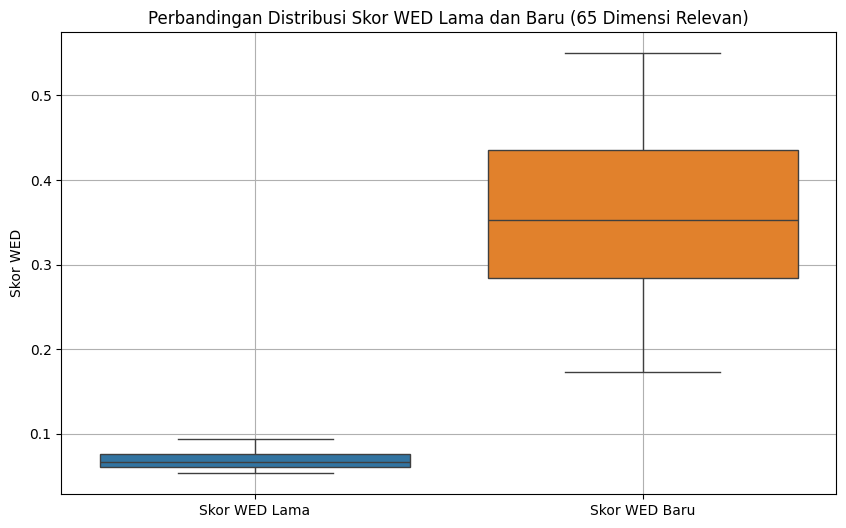


Statistik Skor WED Lama:
count    300.000000
mean       0.068529
std        0.009396
min        0.053136
25%        0.060881
50%        0.066885
75%        0.075992
max        0.093468
dtype: float64

Statistik Skor WED Baru:
count    300.000000
mean       0.356776
std        0.091614
min        0.173007
25%        0.284104
50%        0.352536
75%        0.435691
max        0.549883
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import ast

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Path ke file
path_dataset = '/content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/result_moo.csv'
output_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/result_moo_adjusted.csv'

# Fungsi untuk menghitung max_wed berdasarkan jumlah dimensi relevan
def calculate_max_wed(num_relevant_skills, a=0.5):
    w_max = 1 / (1 + a * 5)  # a = 0.5, max difference = 5
    max_distance_per_skill = w_max * (5**2)
    return np.sqrt(num_relevant_skills * max_distance_per_skill)

# Jumlah dimensi keterampilan yang relevan: 65
relevant_skills = 65
max_wed = calculate_max_wed(relevant_skills)  # ≈ 21.55
print(f"max_wed untuk {relevant_skills} dimensi: {max_wed:.2f}")

# Baca file results_moo.csv
df = pd.read_csv(path_dataset)

# Fungsi untuk mengubah string daftar menjadi daftar Python
def parse_list_column(col):
    return col.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Parse kolom yang berisi daftar
df['company'] = parse_list_column(df['company'])
df['assigned_task'] = parse_list_column(df['assigned_task'])
df['similarity_score'] = parse_list_column(df['similarity_score'])

# Ekstrak semua skor WED lama untuk boxplot
all_scores_old = []
for scores in df['similarity_score']:
    all_scores_old.extend(scores)

# Ubah skor WED lama ke skor WED baru
def adjust_wed_scores(scores, max_wed_value):
    adjusted_scores = []
    for score in scores:
        # Rekonstruksi jarak dari skor lama
        distance = (1 / score) - 1
        # Hitung WED baru
        wed_new = 1 - (distance / max_wed_value)
        # Pastikan skor berada dalam rentang [0, 1]
        wed_new = max(0, min(1, wed_new))
        adjusted_scores.append(wed_new)
    return adjusted_scores

# Terapkan penyesuaian ke setiap baris
df['similarity_score_new'] = df['similarity_score'].apply(lambda x: adjust_wed_scores(x, max_wed))

# Ekstrak semua skor WED baru untuk boxplot
all_scores_new = []
for scores in df['similarity_score_new']:
    all_scores_new.extend(scores)

# Simpan hasil ke CSV baru
df.to_csv(output_path, index=False)
print(f"Hasil disimpan ke: {output_path}")

# Buat boxplot untuk membandingkan distribusi
plt.figure(figsize=(10, 6))
sns.boxplot(data=[all_scores_old, all_scores_new], orient='v')
plt.xticks([0, 1], ['Skor WED Lama', 'Skor WED Baru'])
plt.ylabel('Skor WED')
plt.title('Perbandingan Distribusi Skor WED Lama dan Baru (65 Dimensi Relevan)')
plt.grid(True)
plt.show()

# Tampilkan statistik
print("\nStatistik Skor WED Lama:")
print(pd.Series(all_scores_old).describe())
print("\nStatistik Skor WED Baru:")
print(pd.Series(all_scores_new).describe())